对各种噪声分别进行敏感度测试

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from math import pow

def fractal(branch, layer, prefix='0', reverse=False):
    nodes=[prefix]
    edges=[]
    if reverse:
        for i in range(layer-1):
            new_nodes=[]
            for j in nodes[i]:#为该层的每一个点添加下一层点
                for k in range(1,branch+1):
                    edges.append((j+str(k),j,1.0/pow(branch,i)))
                    new_nodes.append(j+str(k))
            nodes.append(new_nodes)
    else:
        for i in range(layer-1):
            new_nodes=[]
            for j in nodes[i]:#为该层的每一个点添加下一层点
                for k in range(1,branch+1):
                    edges.append((j,j+str(k),1.0/pow(branch,i)))
                    new_nodes.append(j+str(k))
            nodes.append(new_nodes)

    color=['tomato','orange','limegreen','c','dodgerblue','blueviolet','lightgray','peru']
    if reverse:
        color=color[::-1]
    c=[]
    for k,v in enumerate(nodes):
        for i in range(len(v)):
            c.append(color[k])
    return nodes,edges,c

## Creating a graph
做两个形状相同方向相反的分形网络，然后合并中心点
<br>1表示中心点，中层节点用2个数字表示，外层节点用3个数字表示

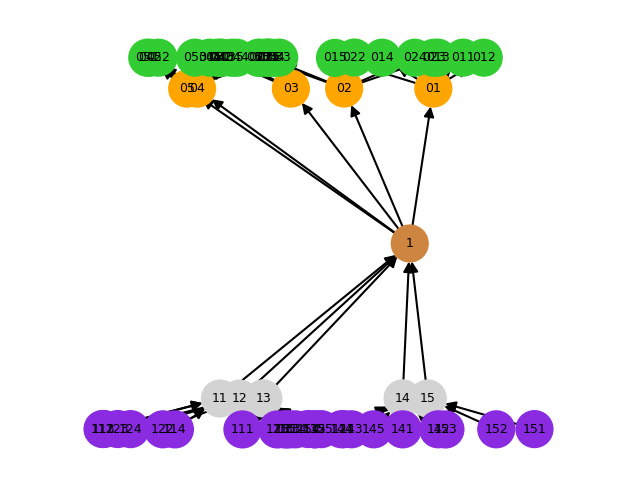

In [8]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4, 3)

G = nx.DiGraph()
nodes,edges,color1=fractal(6,3)
G.add_weighted_edges_from(edges)   
nodes,edges,color2=fractal(6,3,prefix='1',reverse=True)
G.add_node('1')
G.add_weighted_edges_from(edges)  
for k,v in G['0'].items():
    G.add_weighted_edges_from([('1',k,v['weight'])])
G.remove_node('0')

nx.draw_kamada_kawai(G, with_labels=True, node_color=color1[1:]+color2, font_size=6, alpha=1)
plt.show()

## Degree noise
变动外层节点数量，观察中层节点受到的影响

In [9]:
import random
import rolemagnet as rm
from sklearn.metrics.cluster import adjusted_rand_score, homogeneity_completeness_v_measure

rev_G=G.reverse()

n=1
edge_noise=[random.randint(0,n) for i in range(6)]
print(edge_noise)

tempG=G.copy()
for k,mid in enumerate(G['1']):
    for i in list(G[mid])[:edge_noise[k]]:
        tempG.remove_node(i)
for k,mid in enumerate(rev_G['1']):
    for i in list(rev_G[mid])[:edge_noise[k]]:
        tempG.remove_node(i)

true_label=[len(i) if i[0]=='1' else len(i)*2 for i in tempG.nodes]

_,_,label=rm.role_magnet(tempG)

mid_true_label=[]
mid_label=[]
for i,node in enumerate(tempG.nodes):
    if len(node)==2:
        mid_true_label.append(true_label[i])
        mid_label.append(label[i])
print('Adjusted Rand Index:',adjusted_rand_score(mid_true_label,mid_label))
print('V-Measure:',homogeneity_completeness_v_measure(mid_true_label,mid_label))

[1, 0, 1, 0, 1, 0]
Embedding: 100.00%  -
SOM shape: [20, 10]
Training SOM: 220
Adjusted Rand Index: 0.7216494845360825
V-Measure: (1.0, 0.6731852100580318, 0.8046750664676069)


## Edge noise
增加外层节点，并以相反方向的边和中层连接，观察中层节点受到的影响

In [5]:
n=1
edge_noise=[random.randint(0,n) for i in range(6)]
print(edge_noise)

tempG=G.copy()
for k,mid in enumerate(G['1']):
    for i in range(edge_noise[k]):
        tempG.add_weighted_edges_from([(mid+'_'+str(i),mid,0.001)])
for k,mid in enumerate(rev_G['1']):
    for i in range(edge_noise[k]):
        tempG.add_weighted_edges_from([(mid,mid+'_'+str(i),0.001)])
        
true_label=[len(i) if i[0]=='1' else len(i)*2 for i in tempG.nodes]

_,_,label=rm.role_magnet(tempG)

mid_true_label=[]
mid_label=[]
for i,node in enumerate(tempG.nodes):
    if len(node)==2:
        mid_true_label.append(true_label[i])
        mid_label.append(label[i])
print('Adjusted Rand Index:',adjusted_rand_score(mid_true_label,mid_label))
print('V-Measure:',homogeneity_completeness_v_measure(mid_true_label,mid_label))

[0, 1, 0, 1, 1, 0]
Embedding: 100.00%  -
SOM shape: [20, 11]
Training SOM: 135
Adjusted Rand Index: 1.0
V-Measure: (1.0, 1.0, 1.0)


## Weight noise
按比例变动边的权重，观察中层和外层的节点受到的影响

In [6]:
import random
import rolemagnet as rm
from sklearn.metrics.cluster import adjusted_rand_score, homogeneity_completeness_v_measure


n=0.2
tempG=nx.DiGraph()
tempG.add_nodes_from(G)
for node in G.nodes:   
    for k,v in G[node].items():
        tempG.add_weighted_edges_from([(node,k,v['weight']*(1+(random.random()-0.5)*n))])
        
true_label=[len(i) if i[0]=='1' else len(i)*2 for i in tempG.nodes] 
        
_,_,label=rm.role_magnet(tempG)

mid_true_label=[]
mid_label=[]
for i,node in enumerate(tempG.nodes):
    if len(node)!=1:
        mid_true_label.append(true_label[i])
        mid_label.append(label[i])
print('Adjusted Rand Index:',adjusted_rand_score(true_label,label))
print('V-Measure:',homogeneity_completeness_v_measure(true_label,label))

Embedding: 100.00%  -
SOM shape: [20, 12]
Training SOM: 175
Adjusted Rand Index: 1.0
V-Measure: (0.9999999999999999, 1.0, 0.9999999999999999)


## Balance noise
变动流量差，观察中层和外层的节点受到的影响

In [7]:
n=0.1
tempG=G.copy()

true_label=[len(i) if i[0]=='1' else len(i)*2 for i in tempG.nodes]

balance=[(random.random()-0.5)*n for i in range(len(tempG.nodes))]
for i,node in enumerate(tempG.nodes):
    for k,v in tempG[node].items():
        balance[i]-=v['weight']
rev_tempG=tempG.reverse()
for i,node in enumerate(rev_tempG.nodes):
    for k,v in rev_tempG[node].items():
        balance[i]+=v['weight']

_,_,label=rm.role_magnet(tempG, balance=balance)

mid_true_label=[]
mid_label=[]
for i,node in enumerate(tempG.nodes):
    if len(node)!=1:
        mid_true_label.append(true_label[i])
        mid_label.append(label[i])
print('Adjusted Rand Index:',adjusted_rand_score(true_label,label))
print('V-Measure:',homogeneity_completeness_v_measure(true_label,label))

Embedding: 100.00%  -
SOM shape: [5, 10]
Training SOM: 100
Adjusted Rand Index: 1.0
V-Measure: (1.0, 1.0, 1.0)
